In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-12-30 01:53:08.531067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 01:53:08.612654: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-30 01:53:08.615778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 01:53:08.615786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
dataset_name = 'MMD-MA'
dataset_color = 'lime'
modality_names = ['Modality 1', 'Modality 2']
data_folder = '../data/UnionCom/MMD/'
data1 = np.loadtxt(data_folder + "s1_mapped1.txt")
data2 = np.loadtxt(data_folder + "s1_mapped2.txt")
type1 = np.loadtxt(data_folder + "s1_type1.txt")
type2 = np.loadtxt(data_folder + "s1_type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)
type1 = np.array([f'Cell Type {i}' for i in type1])
type2 = np.array([f'Cell Type {i}' for i in type2])

# Labels
labels = [type1, type2]
features = [None, None]
feature_dict = {}

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

/tmp/ipykernel_18390/1053489241.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  type1 = type1.astype(np.int)
/tmp/ipykernel_18390/1053489241.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [8]:
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

Loaded model './saved_models/jm---MMD-MA---300-2000---300-1000.h5'


In [9]:
# Integration (.75)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_75---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_75 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_75.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_75_data = jm_75.fit_transform(dataset=dataset, P=tq_priors)
    jm_75.save_model(model_str)
    np.save(match_str, jm_75.match_result, allow_pickle=True)
jm_75_data = jm_75.transform(dataset=dataset)
integrated_data.append(jm_75_data)
integrated_names.append( 'JAMIE (.75)')
colors.append('lawngreen')
shapes.append('^')

Loaded model './saved_models/jm_75---MMD-MA---300-2000---300-1000.h5'


In [10]:
# Integration (.5)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_50---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_50 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_50.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_50_data = jm_50.fit_transform(dataset=dataset, P=half_priors)
    jm_50.save_model(model_str)
    np.save(match_str, jm_50.match_result, allow_pickle=True)
jm_50_data = jm_50.transform(dataset=dataset)
integrated_data.append(jm_50_data)
integrated_names.append( 'JAMIE (.5)')
colors.append('midnightblue')
shapes.append('d')

Loaded model './saved_models/jm_50---MMD-MA---300-2000---300-1000.h5'


In [11]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model './saved_models/jm_im---MMD-MA---300-2000---300-1000.h5'


# Comparison Methods

In [12]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        dataset_mini[i] = pca.fit_transform(dataset[i])
        # dataset_mini[i] = np.zeros((dataset[i].shape[0], n_components))
        pca_mini.append(pca)

In [13]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data './output_data/NLMA---MMD-MA---300-2000---300-1000.npy'


In [14]:
method_name, method_color, method_shape = 'LMA', 'orange', '*'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data './output_data/LMA---MMD-MA---300-2000---300-1000.npy'


In [15]:
method_name, method_color, method_shape = 'CCA', 'm', 'D'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data './output_data/CCA---MMD-MA---300-2000---300-1000.npy'


In [16]:
method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
in_data = dataset
in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
in_data = [np.matmul(d, d.T) for d in in_data]
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data './output_data/MMD-MA---MMD-MA---300-300---300-300.npy'


In [17]:
method_name, method_color, method_shape = 'UnionCom', 'green', 's'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data './output_data/UnionCom---MMD-MA---300-2000---300-1000.npy'


In [18]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [19]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [20]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

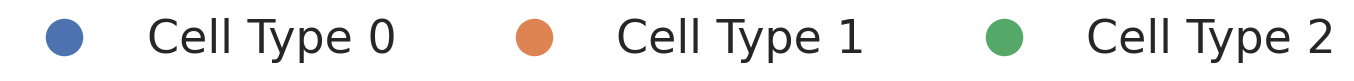

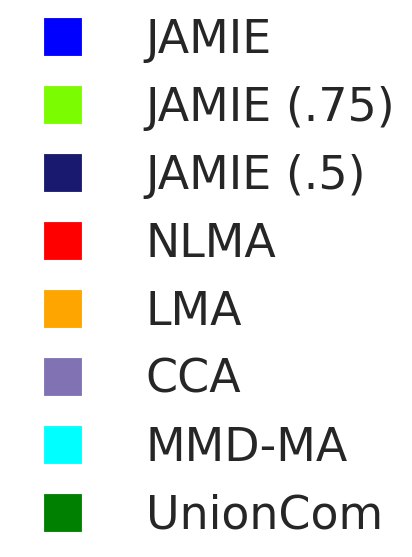

In [21]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

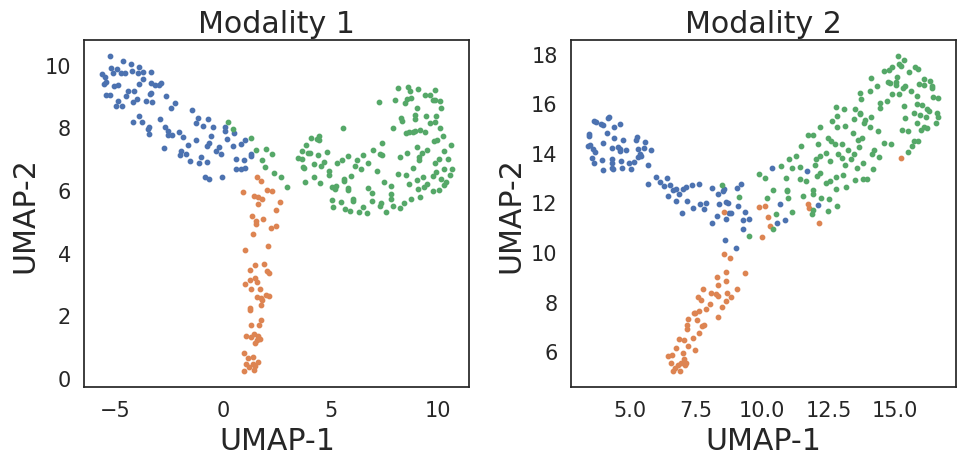

In [22]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')

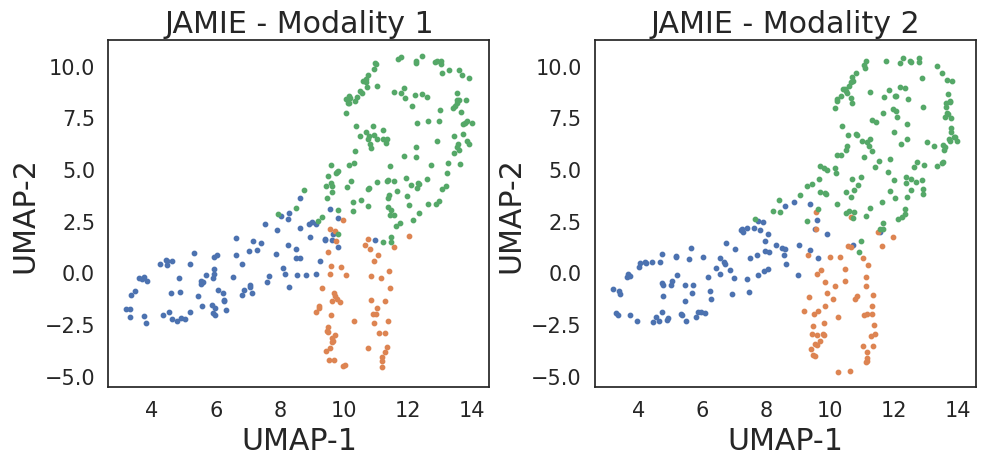

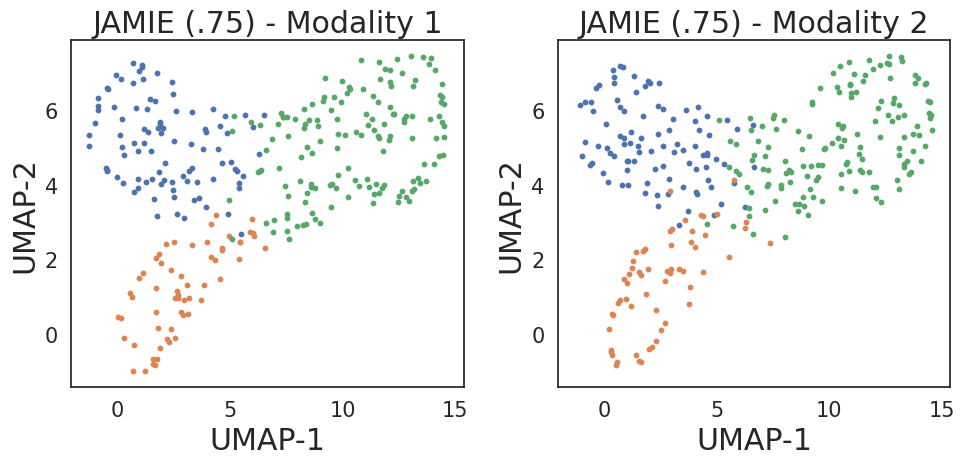

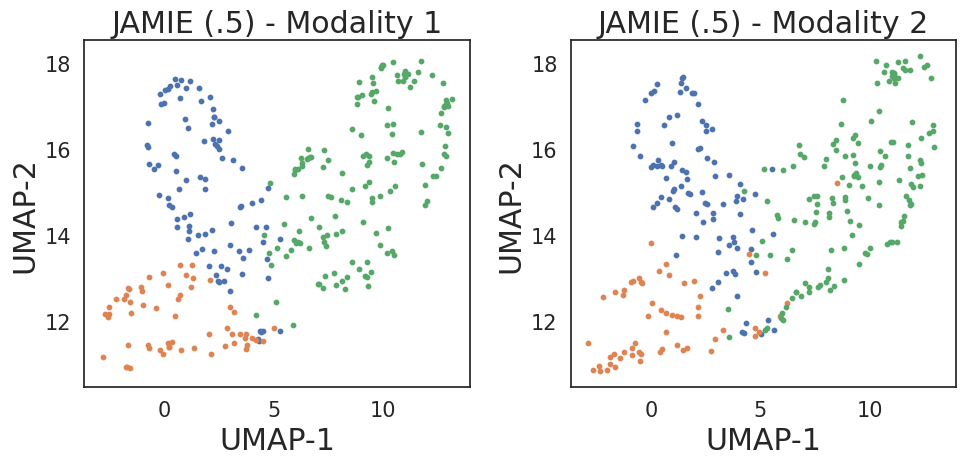

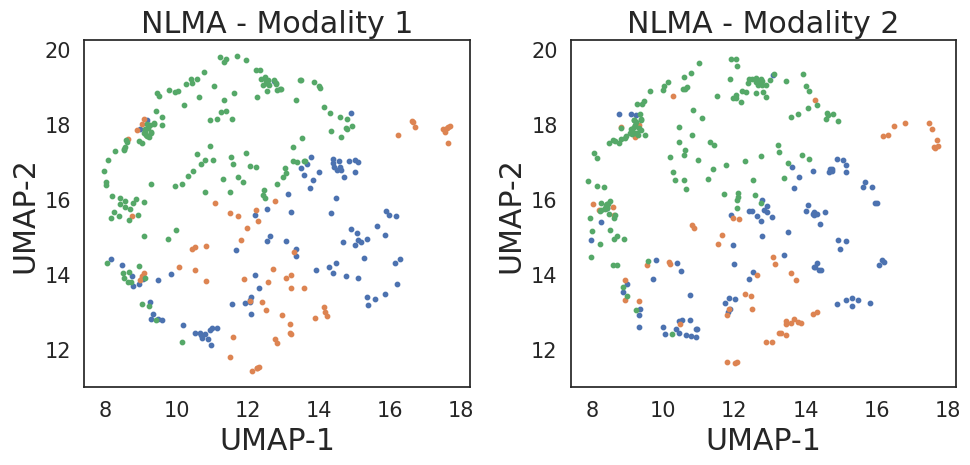

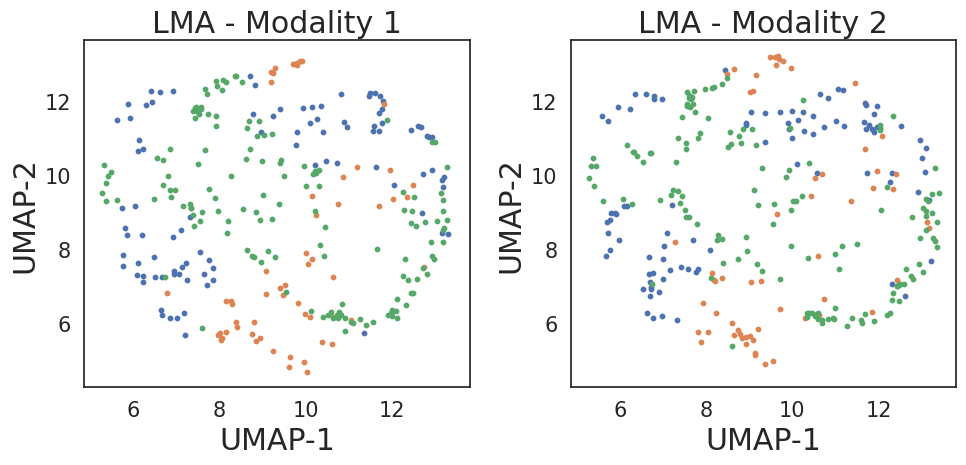

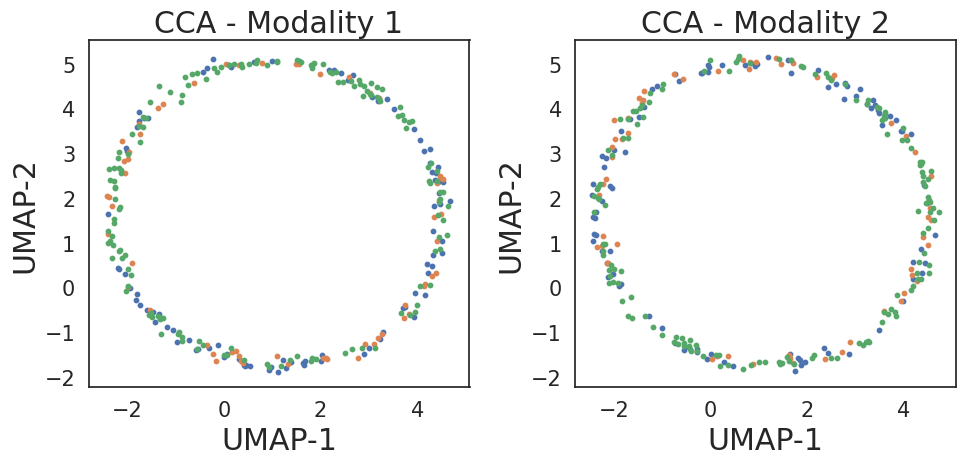

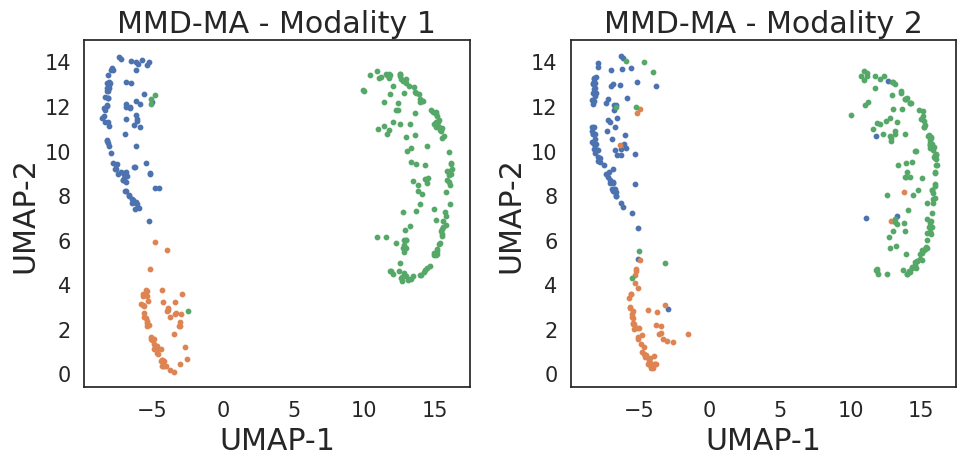

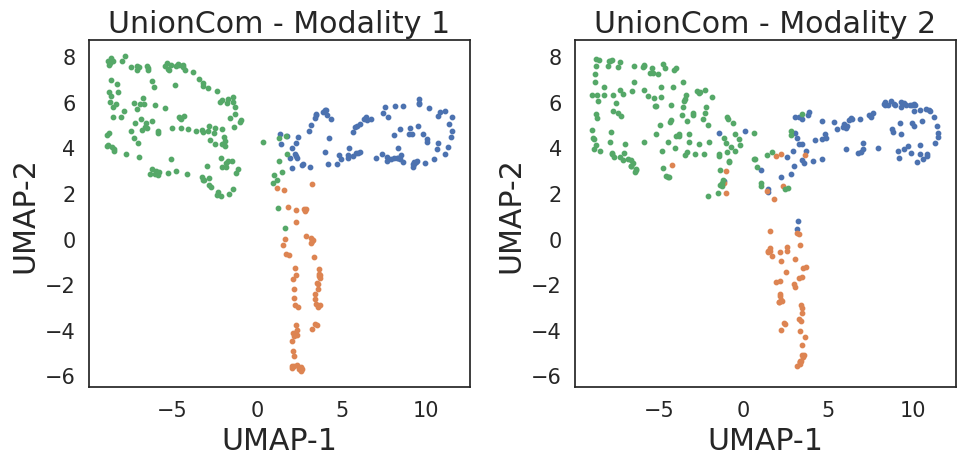

In [23]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.show()

Algorithm     JAMIE  JAMIE (.75)  JAMIE (.5)      NLMA       LMA       CCA  \
LTA        0.976667     0.973333    0.946667  0.970000  0.970000  0.313333   
FOSCTTM    0.001422     0.020183    0.041689  0.000917  0.000917  0.984078   

Algorithm    MMD-MA  UnionCom  
LTA        0.980000  0.946667  
FOSCTTM    0.113078  0.079189  


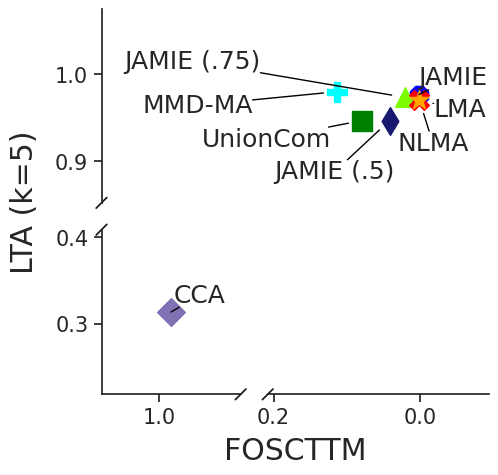

In [24]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors, shapes=shapes)
plt.savefig(image_folder + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')

In [25]:
# plt.figure(figsize=(15, 5))
# plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
# sns.despine()
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Sil.png', dpi=300, bbox_inches='tight')

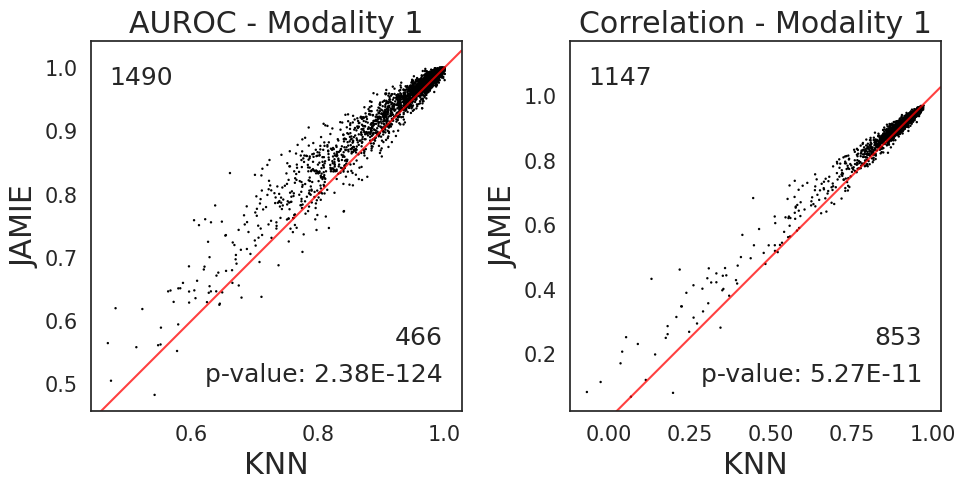

In [26]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')

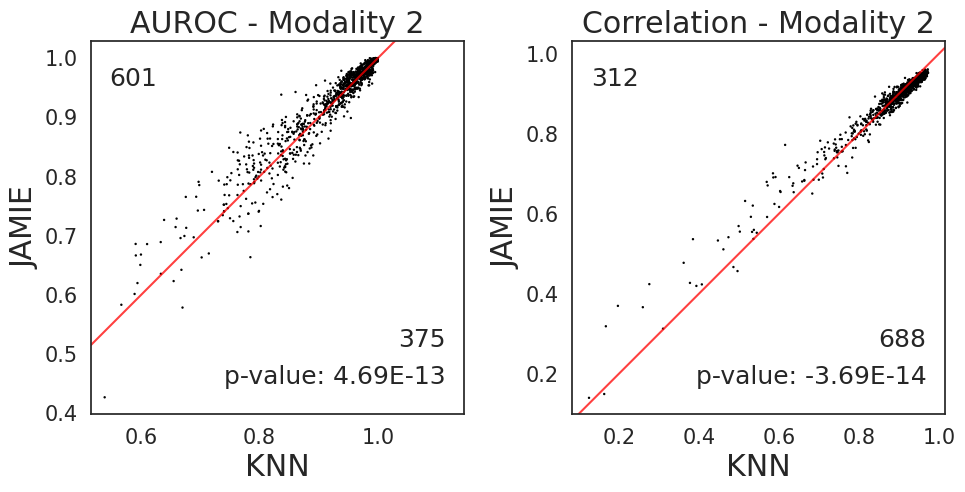

In [27]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')

Feature 388: 0.27754255717797593
Feature 158: 0.28143533713718494


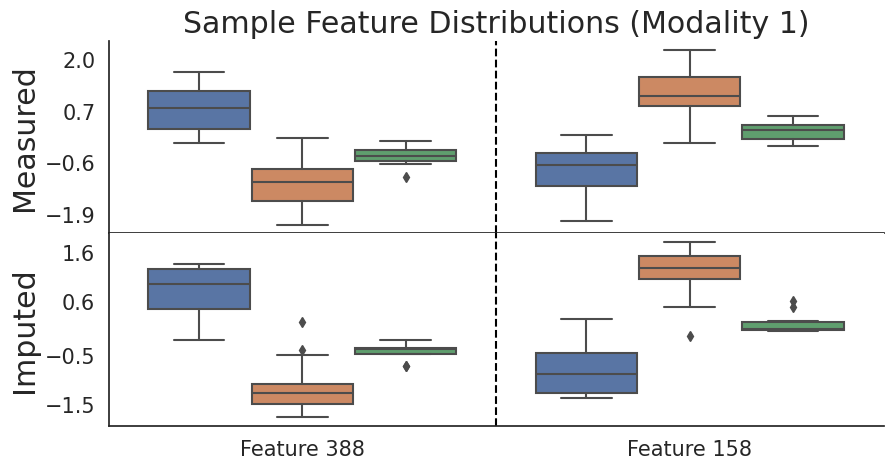

In [28]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')

Feature 568: 0.13992886501111396
Feature 551: 0.15454132936654372


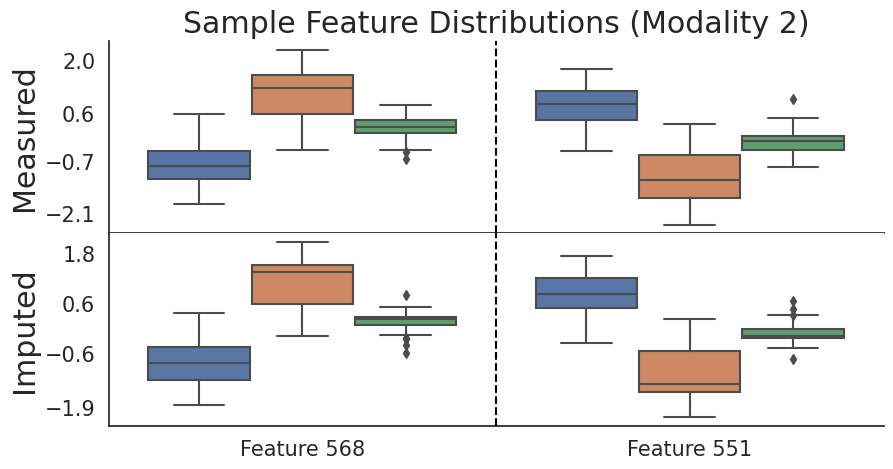

In [29]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1], jm_imputed[1]], 2*[labels[1]], title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')

Mean: 0.428103294751881
Std: 0.09725732484186839


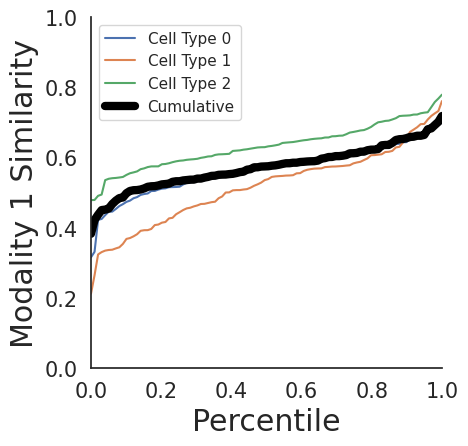

In [30]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], relative=False)
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')

Mean: 0.47261454141985604
Std: 0.10993881470976175


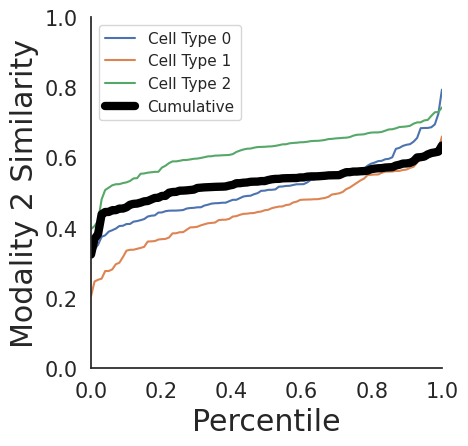

In [31]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')

# Explanation

In [32]:
mod0, mod1 = 0, 1
current_jm = jm
analysis_base = f'{output_folder}JAMIE---{size_str}---'
analysis_str = analysis_base + 'sorted_genes'

In [33]:
# LTA
target_name = 'LTA'
Ly = current_jm.transform_one(dataset[mod1], mod1)
function = lambda x: current_jm.test_LabelTA([current_jm.transform_one(x, mod0), Ly], labels)
perf_function = lambda x, y: x
true = None

# Imputation
# target = sort_by_interest([dataset[mod1], current_jm.modal_predict(dataset[mod0], mod0)], limit=20, remove_outliers=True)[1][1]
# target_name = features[mod1][target] + '\nCorrelation'
# function = lambda x: current_jm.modal_predict(x, mod0)[:, target]
# true = dataset[mod1][:, target]
# from scipy.stats import pearsonr
# perf_function = lambda x, y: pearsonr(x, y)[0]

testing_idx = np.array(range(dataset[mod0].shape[1]))
# testing_idx = sort_by_interest([dataset[mod0], dataset[mod0]], limit=1000, remove_outliers=False)[1]
# testing_idx = np.random.choice(dataset[mod0].shape[0], 1000, replace=False)
# scan = None
scan = 100

if not os.path.exists(analysis_str):
    baseline, performance, new_idx = evaluate_impact(function, perf_function, dataset[mod0], true, features[mod0], idx=testing_idx, scan=scan)
    argsort = np.argsort(performance)
    sorted_idx = new_idx[argsort]
    sorted_names = features[mod0][sorted_idx]
    sorted_names = np.array([s.replace(' ', '_') for s in sorted_names])
    sorted_perf = performance[argsort]
    
    file_contents = np.concatenate([sorted_idx.reshape((-1, 1)), sorted_names.reshape((-1, 1)), sorted_perf.reshape((-1, 1))], axis=1)
    file_contents_str = '\n'.join([' '.join([str(s) for s in r]) for r in file_contents]) + '\n'
    with open(analysis_str, 'w') as f:
        f.write(file_contents_str)
else:
    baseline = perf_function(function(dataset[mod0]), true)
    sorted_idx = []
    sorted_names = []
    sorted_perf = []
    with open(analysis_str, 'r') as f:
        for line in f:
            idx, names, perf = line[:-1].split(' ')
            sorted_idx.append(int(idx))
            sorted_names.append(str(names))
            sorted_perf.append(float(perf))
    sorted_idx, sorted_names, sorted_perf = np.array(sorted_idx), np.array(sorted_names), np.array(sorted_perf)
    performance = sorted_perf

In [34]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = sorted_names[:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target Modality 2 Feature: LTA
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LTA
Important Modality 1 Features: Feature_1999, Feature_1978, Feature_1977, Feature_1976, Feature_1975, Feature_1974, Feature_1973, Feature_1972, Feature_1971, Feature_1970, Feature_1969, Feature_1968, Feature_1967, Feature_1966, Feature_1965, Feature_1951, Feature_1979, Feature_1980, Feature_1998, Feature_1982
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1999
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1978
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1977
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1976
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1975
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1974
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1973
0.49000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature_1972
0.49000: https://www

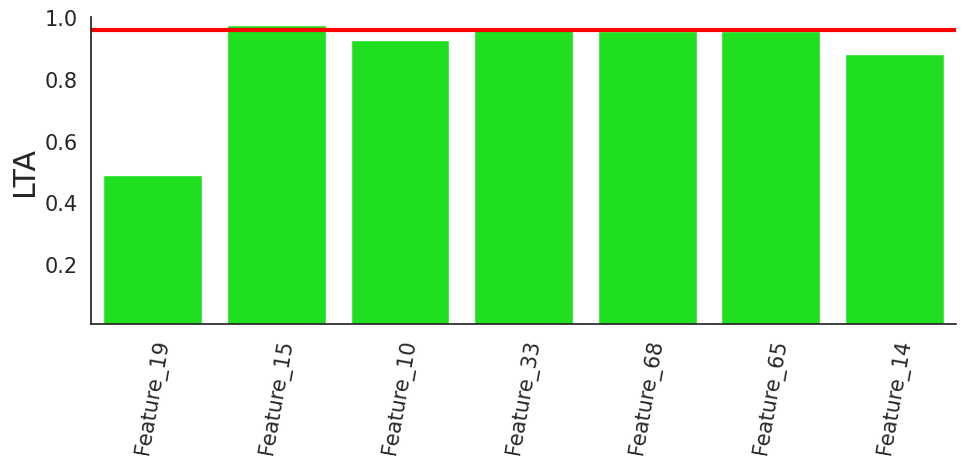

In [35]:
plt.figure(figsize=(10, 5))
plot_impact(sorted_perf, sorted_names, baseline, max_features=20, color=dataset_color)
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Analysis.png', dpi=300, bbox_inches='tight')